# **Resturant Recomendation By Food Review DataSet**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, string, re, random, gc, pickle, math,warnings
from tqdm.keras import TqdmCallback
from tqdm import tqdm
from scipy.sparse import csr_matrix

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
from nltk.corpus import stopwords

# Transformers
import transformers
from transformers import pipeline

# Sklearn
from sklearn.model_selection import *
from sklearn.feature_extraction import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.utils import *
from sklearn.pipeline import *
from sklearn.compose import *
from sklearn.metrics.pairwise import linear_kernel,laplacian_kernel


# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import *
from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import *
from tensorflow.keras.callbacks import *

# Setting
pd.set_option('max_colwidth',None)
seed = random.randint(1,100)
warnings.simplefilter('ignore')
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


## **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Load The Data And Process It**

In [ ]:
XLSX = '/content/drive/MyDrive/Colab Notebooks/Food Review Dataset of Bangladesh.xlsx'
Sheet = 'Sheet1'

# Load
raw = pd.read_excel(XLSX,sheet_name=Sheet)

# Drop Column(s)
unwanted = ['reviewer_name','ratings','review_text','scraper','text','time']
df = raw.drop(unwanted,axis=1,inplace=False)

# Sampling 'n' samples
n = 8300
df = df.sample(n)

# Drop Nulls & Duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Reset Index
df.reset_index(drop=True,inplace=True)

# View
df.head()

,ratings_int,restaurant,city,preprocessed_text
0,5,Mehedi Hotel & Restaurant,Rajshahi,too much tasty
1,4,Arrow Spoon,Rajshahi,the quality and quantity wasn t liked according to the price
2,5,Chinese Palace,Comilla,always delicious
3,4,Golden Spoon Khulna,Comilla,good
4,2,Sunami,Dhaka,need to improve the quality


## **Sentiment Analysis**

In [ ]:
sentiments = []

for t in tqdm(df['preprocessed_text'].tolist()):
    sentiment_ouput = sentiment_pipeline(t)
    for so in sentiment_ouput:
        sentiments.append(so['label'].title())

# Add New Column
df['sentiment'] = sentiments


# View
df.head()

100%|██████████| 8147/8147 [07:17<00:00, 18.61it/s]


,ratings_int,restaurant,city,preprocessed_text,sentiment
0,5,Mehedi Hotel & Restaurant,Rajshahi,too much tasty,Positive
1,4,Arrow Spoon,Rajshahi,the quality and quantity wasn t liked according to the price,Negative
2,5,Chinese Palace,Comilla,always delicious,Positive
3,4,Golden Spoon Khulna,Comilla,good,Positive
4,2,Sunami,Dhaka,need to improve the quality,Negative


**Mean Rating Calculaton**

In [ ]:
restaurants = list(df['restaurant'].unique())
df['mean_rating'] = 0

for i in range(len(restaurants)):
    df['mean_rating'][df['restaurant'] == restaurants[i]] = df['ratings_int'][df['restaurant'] == restaurants[i]].mean()

#Scaling the mean rating values
scaler = MinMaxScaler(feature_range = (1,5))
df[['mean_rating']] = scaler.fit_transform(df[['mean_rating']]).round(2)

# View
df.head()

,ratings_int,restaurant,city,preprocessed_text,sentiment,mean_rating
0,5,Mehedi Hotel & Restaurant,Rajshahi,too much tasty,Positive,3.33
1,4,Arrow Spoon,Rajshahi,the quality and quantity wasn t liked according to the price,Negative,3.03
2,5,Chinese Palace,Comilla,always delicious,Positive,3.58
3,4,Golden Spoon Khulna,Comilla,good,Positive,1.69
4,2,Sunami,Dhaka,need to improve the quality,Negative,2.73


## Distribution Of Resturant Rating

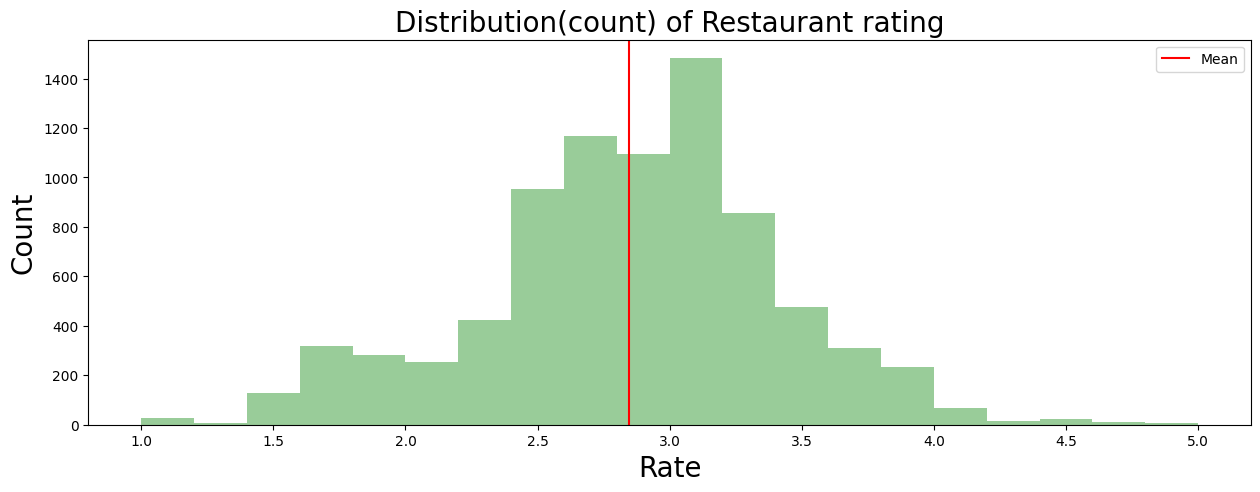

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.distplot(df.mean_rating,kde=False,color = 'g',ax =ax,bins=20);
ax.axvline(df.mean_rating.mean(), 0, 1, color='r', label='Mean')
ax.legend();
ax.set_ylabel('Count',size=20)
ax.set_xlabel('Rate',size=20)
ax.set_title('Distribution(count) of Restaurant rating',size=20);

## Top 10 Resturant List

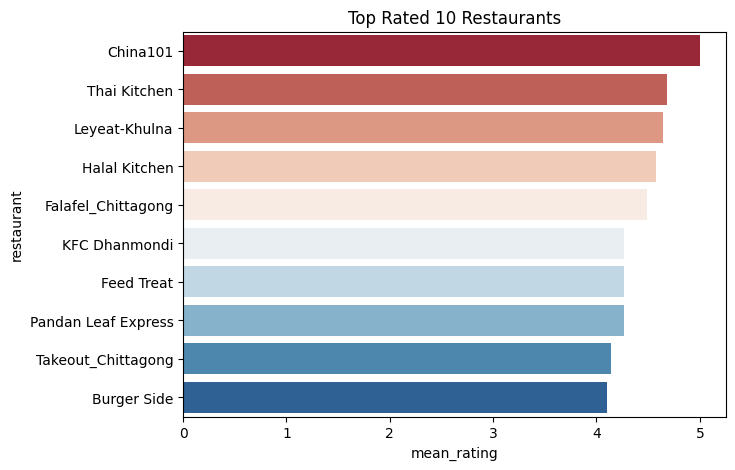

In [ ]:
df_rating = df.drop_duplicates(subset='restaurant')
df_rating = df_rating.sort_values(by='mean_rating', ascending=False).head(10)
plt.figure(figsize=(7,5))
sns.barplot(data=df_rating, x='mean_rating', y='restaurant', palette='RdBu')
plt.title('Top Rated 10 Restaurants');

## **Sentiment Distribution**

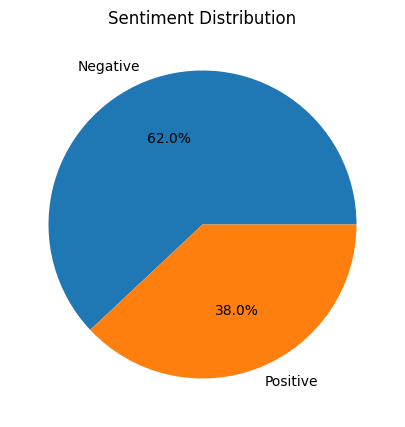

In [ ]:
df_sentiment = pd.DataFrame(df.groupby('sentiment').size(),columns=['Count'])
plt.figure(figsize=(7,5))
plt.pie(df_sentiment['Count'], labels=df_sentiment.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

## Most Famous Resturant

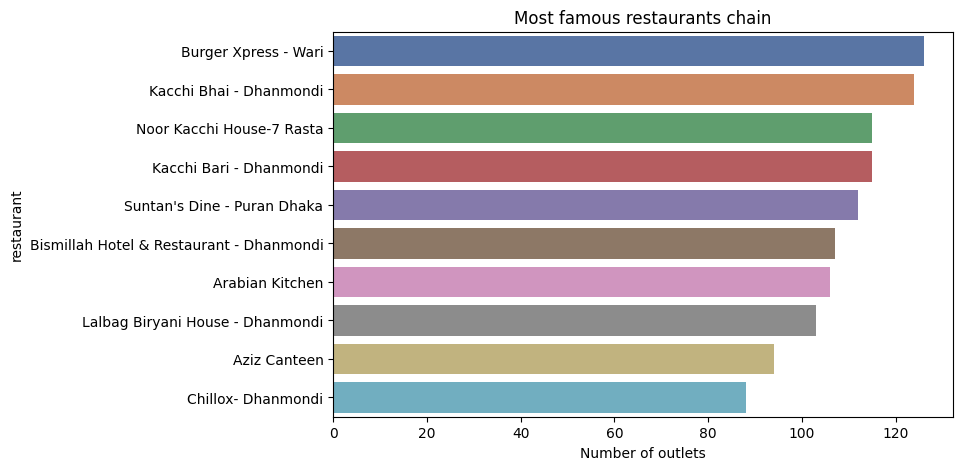

In [ ]:
plt.figure(figsize=(8,5))
#chains=df['restaurant'].value_counts()[:10]
chains = pd.DataFrame(df.groupby(['restaurant','city']).size().sort_values(ascending=False),columns=['Count'])[:10]
sns.barplot(x=chains['Count'],y=chains.index.get_level_values("restaurant"),palette='deep')
plt.title("Most famous restaurants chain")
plt.xlabel("Number of outlets")
plt.show()

### **Testing Sentiments**

In [ ]:
df.sample(5)

,ratings_int,restaurant,city,preprocessed_text,sentiment,mean_rating
6819,4,Prince Burger,Dhaka,gd,Negative,3.05
6160,4,Brick Lane Café,Comilla,it s as it should be but i don t really like the thing it is not possible but i have given the rating correctly because it did not bother to give meat,Positive,3.33
27,1,Chillox - Lalbagh,Dhaka,incomplete order i ordered items burgers and wings one burger did not arrive,Negative,2.86
7256,2,Kitchen Express- Khulna,Comilla,food was tasty but in this price they are cheating with their customers because it s about tk with delivery but the quantity is very low and the meatpieces is just and also tiny,Negative,3.05
6544,1,Dhakai Biryani House,Comilla,salat where there is no salat i ordered three packets of tehri but no salat,Negative,2.11


## **Word Frequency Distributions**

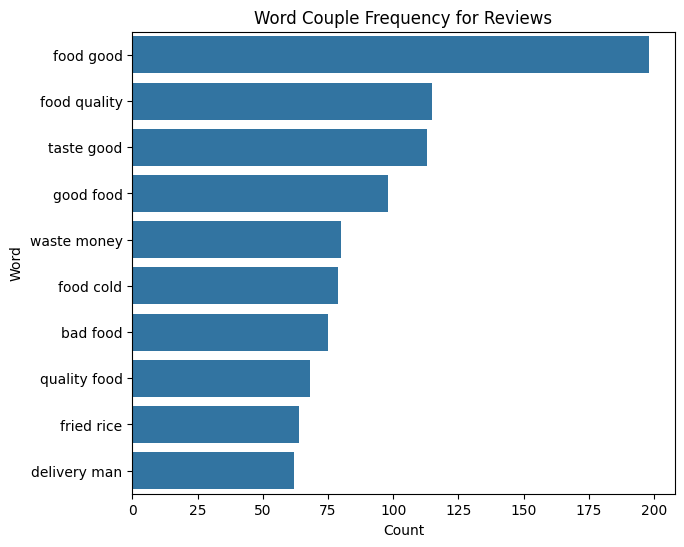

In [ ]:
def get_top_words(column, top_nu_of_words, nu_of_word):

    vec = text.CountVectorizer(ngram_range= nu_of_word, stop_words='english')
    bag_of_words = vec.fit_transform(column)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_nu_of_words]

# Top n word frequencies for reviews
n = 10  # no. of words
lst = get_top_words(df['preprocessed_text'], n, (2,2))
df_words = pd.DataFrame(lst, columns=['Word', 'Count'])
plt.figure(figsize=(7,6))
sns.barplot(data=df_words, x='Count', y='Word')
plt.title('Word Couple Frequency for Reviews');
plt.show()

## **Recomandations**

In [ ]:
df_review = df[['restaurant','city','preprocessed_text','sentiment','mean_rating']]
df_review.set_index('restaurant', inplace=True)
indices = pd.Series(df_review.index)

# Creating tf-idf matrix
tfidf = text.TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_review['preprocessed_text'])

# Consine Similarities
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
def recommend(name, cosine_similarities = cosine_similarities):

    recommend_restaurant = []

    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]

    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)

    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)

    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_review.index)[each])

    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['city', 'mean_rating', 'sentiment'])

    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        # df_new = df_new.append(pd.DataFrame(df_review[['city', 'mean_rating', 'sentiment']][df_review.index == each].sample()))
        df_new = pd.concat([df_new,pd.DataFrame(df_review[['city', 'mean_rating', 'sentiment']][df_review.index == each].sample())], ignore_index=False)

    # Drop the same named restaurants and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['city', 'mean_rating', 'sentiment'], keep=False)
    df_new = df_new.sort_values(by='mean_rating', ascending=False).head(5)

    print('TOP %s RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ' % (str(len(df_new)), name))

    return df_new

In [ ]:
recommend('Kacchi Bhai - Dhanmondi')

TOP 5 RESTAURANTS LIKE Kacchi Bhai - Dhanmondi WITH SIMILAR REVIEWS: 


,city,mean_rating,sentiment
Haji Kacchi Ghor - Barishal,Barisal,3.62,Positive
Kacchi Bari - Dhanmondi,Dhaka,3.17,Positive
Bangla Tiffin,Rajshahi,3.12,Negative
Tehari Ghar- Kalabagan,Dhaka,3.03,Negative
Lalbag Biryani House - Dhanmondi,Dhaka,2.97,Positive


In [ ]:
recommend('Barcode Cafe_Chittagong')

TOP 5 RESTAURANTS LIKE Barcode Cafe_Chittagong WITH SIMILAR REVIEWS: 


,city,mean_rating,sentiment
Haji Kacchi Ghor - Barishal,Barisal,3.62,Positive
North End,Dhaka,3.62,Positive
Zafran Restaurant - Sylhet,Sylhet,3.61,Positive
Rany's Mom Kitchen,Comilla,3.53,Positive
Master Chef Bangla Restora,Rajshahi,3.47,Negative


## **Recommned Restaurant By locations**

In [ ]:
def recommend_by_location(name, cosine_similarities=cosine_similarities):
    recommend_restaurant = []

    # Get city of the input restaurant (first occurrence only)
    try:
        input_city = df_review.loc[name].iloc[0]['city'] if isinstance(df_review.loc[name], pd.DataFrame) else df_review.loc[name]['city']
    except KeyError:
        print(f"Restaurant '{name}' not found in the dataset.")
        return pd.DataFrame()

    # Find the index of the restaurant
    idx = indices[indices == name].index[0]

    # Get top cosine similarity scores
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)

    # Extract top similar restaurant indexes (excluding the input one itself)
    top_indexes = list(score_series.iloc[1:51].index)  # skip input itself

    # Get restaurant names
    for i in top_indexes:
        recommend_restaurant.append(df_review.index[i])

    # Build the dataframe with city filtering
    df_new = pd.DataFrame(columns=['city', 'mean_rating', 'sentiment'])

    for rest in recommend_restaurant:
        try:
            city_of_rest = df_review.loc[rest].iloc[0]['city'] if isinstance(df_review.loc[rest], pd.DataFrame) else df_review.loc[rest]['city']
            if city_of_rest == input_city:
                df_temp = df_review[['city', 'mean_rating', 'sentiment']].loc[[rest]].drop_duplicates()
                df_new = pd.concat([df_new, df_temp])
        except KeyError:
            continue

    # Finalize: sort by rating
    df_new = df_new.sort_values(by='mean_rating', ascending=False).head(5)

    print(f"TOP {len(df_new)} RESTAURANTS IN {input_city.upper()} SIMILAR TO '{name}':")
    return df_new


In [ ]:
recommend_by_location("Kacchi Bhai - Dhanmondi")


TOP 5 RESTAURANTS IN DHAKA SIMILAR TO 'Kacchi Bhai - Dhanmondi':


,city,mean_rating,sentiment
Cafe Euphoria,Dhaka,3.18,Negative
Cafe Euphoria,Dhaka,3.18,Positive
Madchef - Dhanmondi,Dhaka,3.18,Positive
Madchef - Dhanmondi,Dhaka,3.18,Negative
Kacchi Bari - Dhanmondi,Dhaka,3.17,Negative


In [ ]:
recommend_by_location('Barcode Cafe_Chittagong')

TOP 2 RESTAURANTS IN CHITTAGONG SIMILAR TO 'Barcode Cafe_Chittagong':


,city,mean_rating,sentiment
KFC_Chittagong,Chittagong,2.64,Positive
KFC_Chittagong,Chittagong,2.64,Negative
